In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

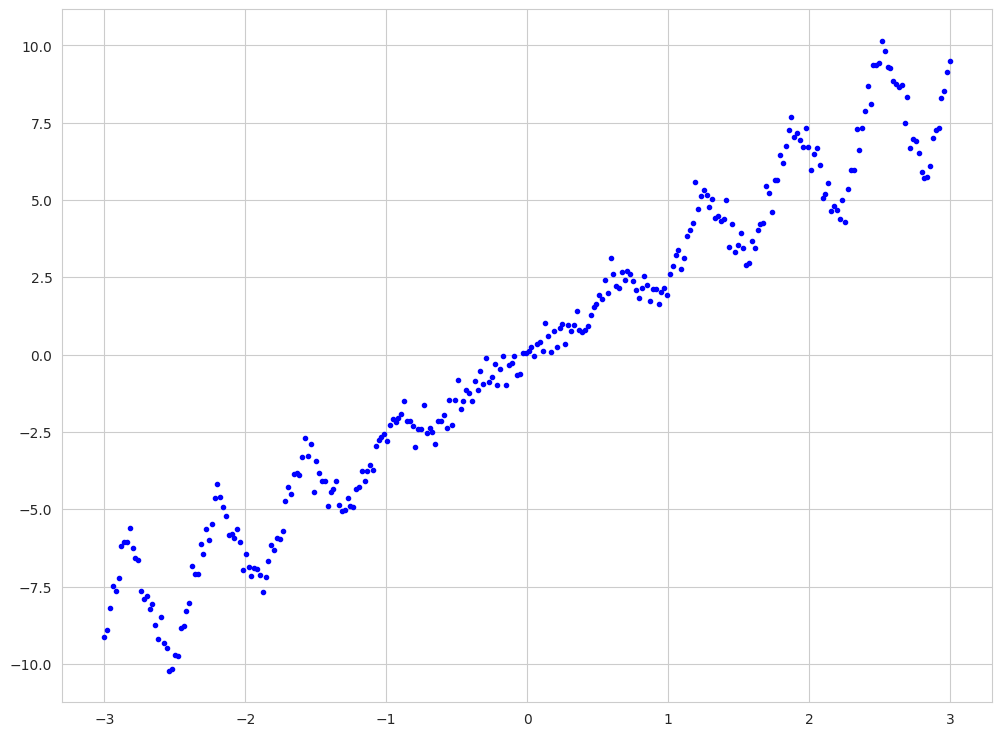

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$", i = 0):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

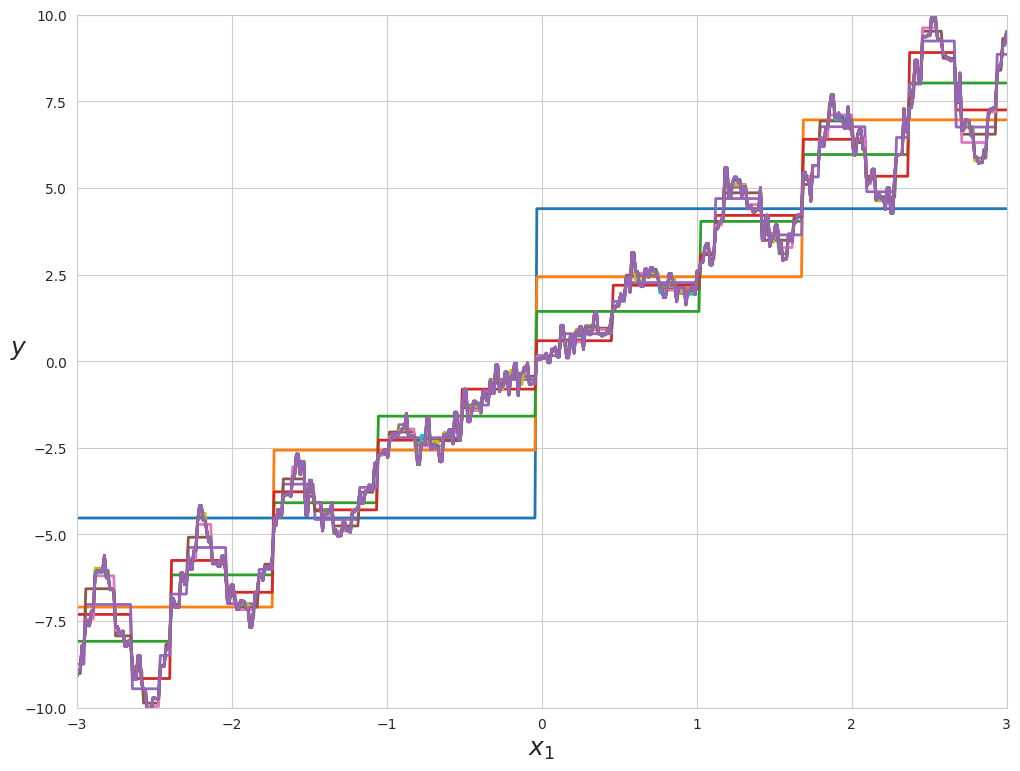

In [5]:
for i in range(1,16):
    tree_reg = DecisionTreeRegressor(max_depth=i)
    tree_reg.fit(X,y)
    plot_regression_predictions(tree_reg, X, y)
plt.show()

У меня не получилось добавить легенду, поэтому уменьшим диапозон и шаг, например, не с 1, а с 4, потому что первые три точно плохо описывают.

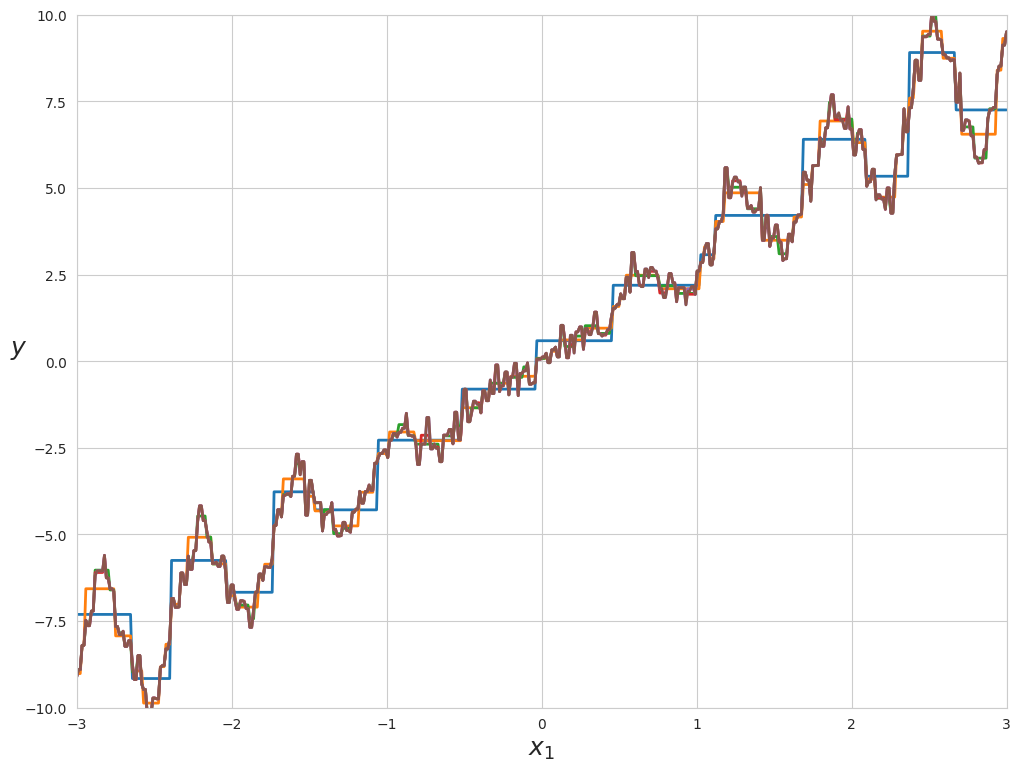

In [6]:
for i in range(4,16,2):
    tree_reg = DecisionTreeRegressor(max_depth=i)
    tree_reg.fit(X,y)
    plot_regression_predictions(tree_reg, X, y)
plt.show()

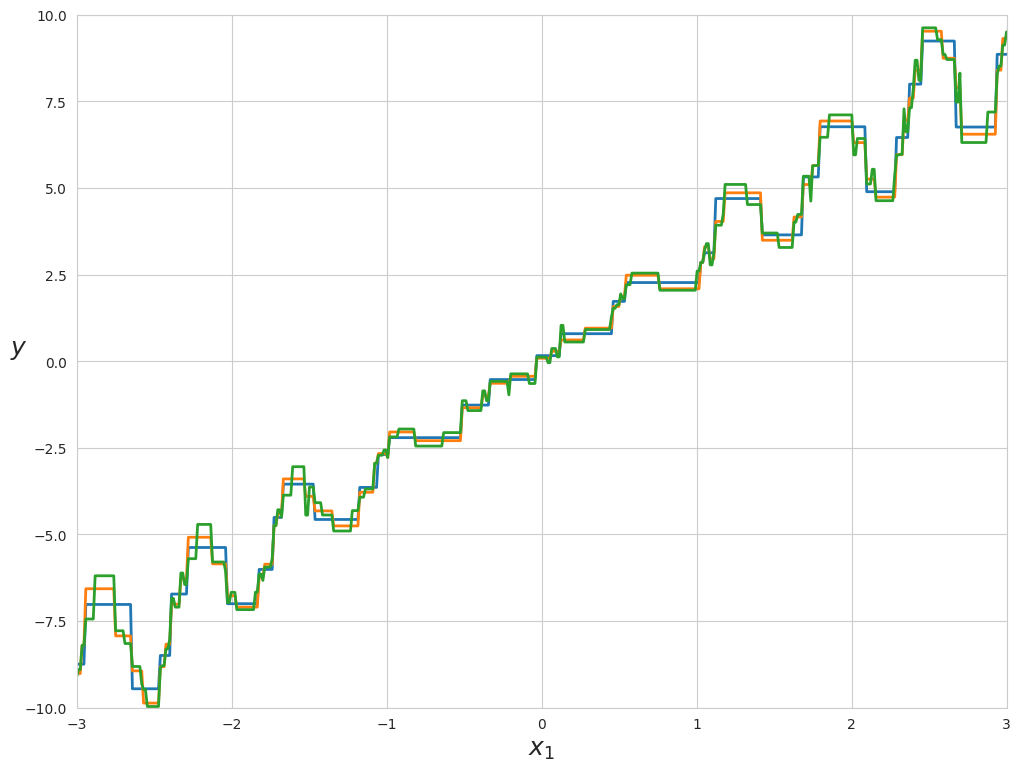

In [7]:
for i in range(5,8):
    tree_reg = DecisionTreeRegressor(max_depth=i)
    tree_reg.fit(X,y)
    plot_regression_predictions(tree_reg, X, y)
plt.show()

7 уже плохо, потому что начинаются острые пики, которые учитывают шум, поэтому идеальная глубина 5,6.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$






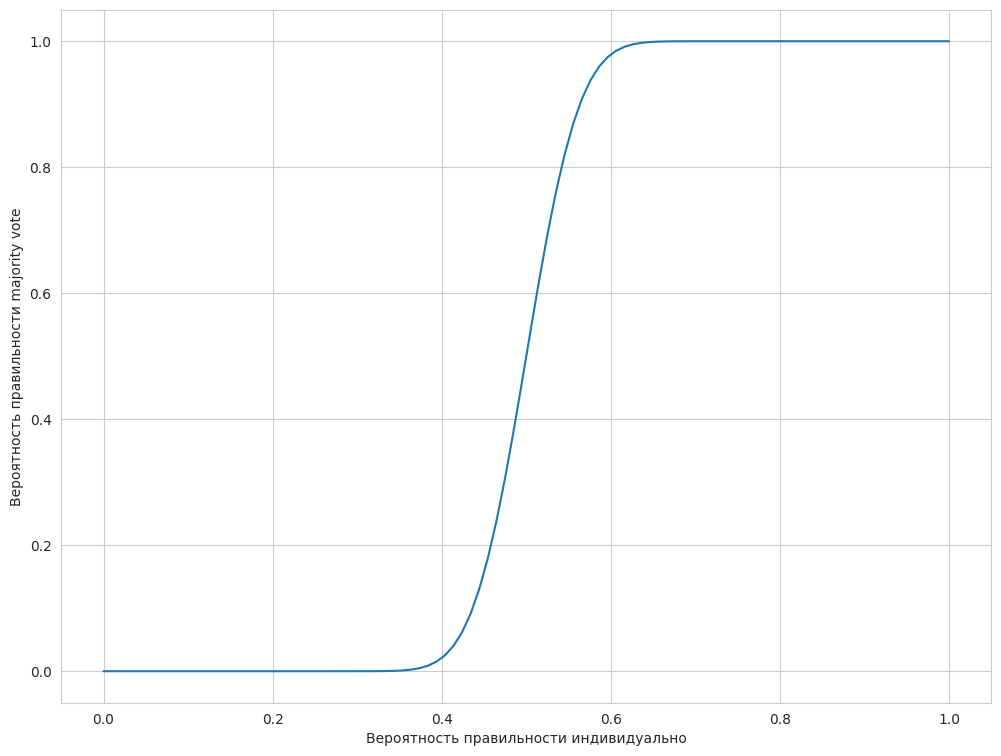

In [8]:
p_values = np.linspace(0, 1, 100)
majority_vote_probabilities = []
for p in p_values:
    mu = np.sum([np.math.comb(101, i) * (p ** i) * ((1 - p) ** (101 - i)) for i in range(51, 102)])
    majority_vote_probabilities.append(mu)
plt.plot(p_values, majority_vote_probabilities)
plt.xlabel("Вероятность правильности индивидуально")
plt.ylabel("Вероятность правильности majority vote")
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [9]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

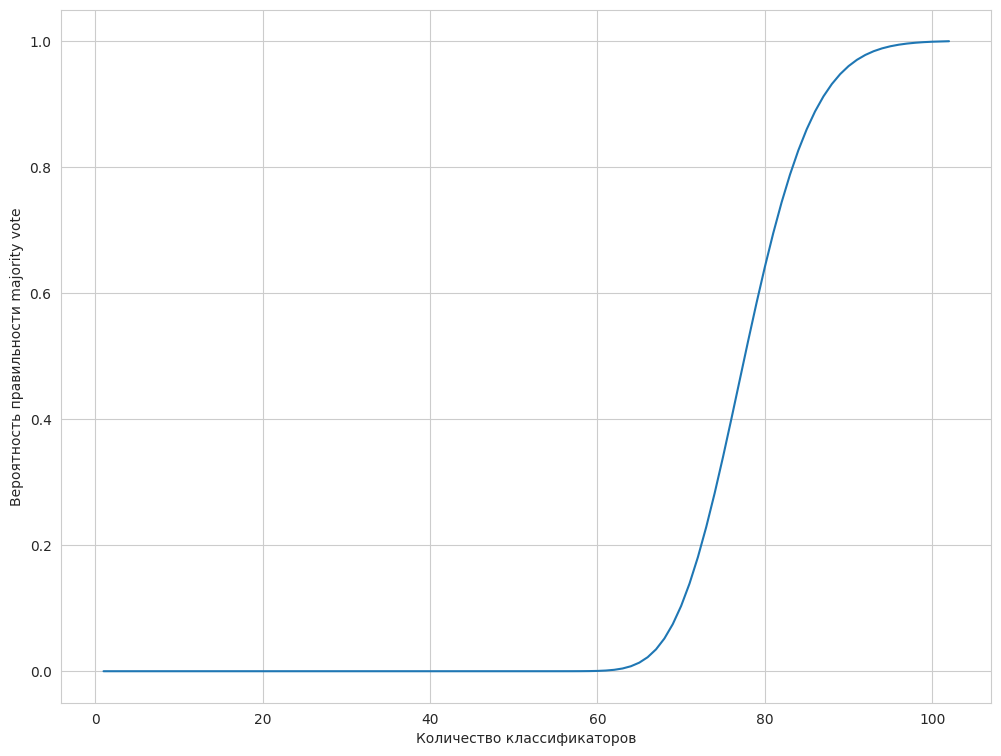

In [10]:
n_classes = list(map(int, np.linspace(1, 102, 101)))
p = 0.65
majority_vote_probabilities = []
for n in n_classes:
    mu = np.sum([np.math.comb(n, i) * (p ** i) * ((1 - p) ** (n - i)) for i in range(51, 102)])
    majority_vote_probabilities.append(mu)
plt.plot(n_classes, majority_vote_probabilities)
plt.xlabel("Количество классификаторов")
plt.ylabel("Вероятность правильности majority vote")
plt.show()

Опишите ваши наблюдения:

* Для хорошего предсказания 101 классификатор как раз
* Индивидуальная вероятность тоже после 0.6 как раз тоже хорошая для хорошего предсказания общего (это по первому графику видно)

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [11]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        pass

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        pass
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [12]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

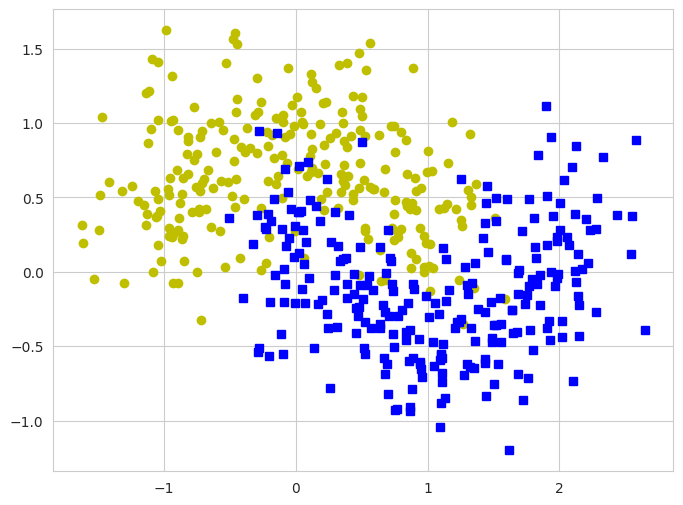

In [13]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [14]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [15]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [16]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [17]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
print(breast_cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

Всего 30 фич нам доступно.

In [19]:
cor_table = []
max_features = [1, 2, 3, 4, 6, 8, 12, 16, 20, 25, 30]
for feat in max_features:
    rfc_mod = RandomForestClassifier(max_features=feat)
    rfc_mod.fit(X_train, y_train)
    cor_table.append(base_model_pair_correlation(rfc_mod, X_test))

In [20]:
cor_df = pd.DataFrame(cor_table, index = [1, 2, 3, 4, 6, 8, 12, 16, 20, 25, 30]).transpose() #перевернем таблицу, а то боксплоты потом не построить
cor_df.head()

,1,2,3,4,6,8,12,16,20,25,30
0,0.754200,0.724487,0.897039,0.884723,0.753589,0.785363,0.767000,0.850130,0.847912,0.825457,0.842448
1,0.725271,0.624899,0.825303,0.839169,0.779246,0.856527,0.778513,0.887541,0.847912,0.854835,0.783874
2,0.674025,0.710297,0.843298,0.838937,0.677135,0.788652,0.753589,0.771289,0.760260,0.825457,0.870574
3,0.695022,0.582731,0.867503,0.780013,0.733731,0.838292,0.740402,0.815620,0.897167,0.823123,0.899359
4,0.738925,0.606686,0.814330,0.765567,0.734466,0.751385,0.767000,0.872265,0.897167,0.766701,0.856426


In [21]:
cor_df.describe()

,1,2,3,4,6,8,12,16,20,25,30
count,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000
mean,0.721746,0.762353,0.789664,0.786202,0.812024,0.817745,0.824306,0.831610,0.829582,0.838884,0.831844
std,0.072557,0.065164,0.056785,0.054269,0.053726,0.050952,0.049403,0.048862,0.052949,0.047774,0.048729
min,0.429512,0.538337,0.565235,0.594370,0.584818,0.660857,0.652272,0.662348,0.608001,0.620292,0.655122
25%,0.674025,0.718437,0.753589,0.751385,0.779246,0.782924,0.793571,0.799227,0.795868,0.810679,0.798396
50%,0.725271,0.765567,0.792647,0.786434,0.813388,0.816606,0.825963,0.829415,0.829215,0.840527,0.829522
75%,0.773311,0.809908,0.827496,0.824969,0.852273,0.853641,0.856527,0.867591,0.869206,0.869976,0.867591
max,0.925445,0.957528,0.971247,0.957052,0.970246,0.969523,0.970828,0.970681,1.000000,0.985285,0.985384


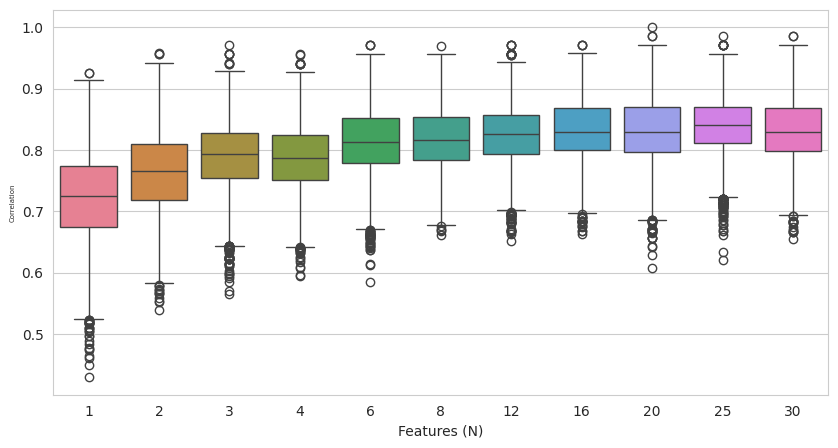

In [22]:
plt.figure(figsize=(10,5));

sns.boxplot(data=cor_df);
plt.xlabel("Features (N)", size=10);
plt.ylabel("Correlation", size=5);

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

Как глубину прикинуть, ее пределы, я не поняла, поэтому поставлю как чувствую.

In [23]:
cor_table_depth = []
max_depths = [1, 2, 5, 10, 25, 50, 100]
for depth in max_depths:
    rfc_mod = RandomForestClassifier(max_depth=depth)
    rfc_mod.fit(X_train, y_train)
    cor_table_depth.append(base_model_pair_correlation(rfc_mod, X_test))

In [24]:
cor_df_depth = pd.DataFrame(cor_table_depth, index = [1, 2, 5, 10, 25, 50, 100]).transpose()
cor_df_depth.head()

,1,2,5,10,25,50,100
0,0.744165,0.769327,0.735983,0.851228,0.852675,0.813755,0.815384
1,0.813388,0.814268,0.765980,0.793571,0.823123,0.758870,0.773561
2,0.674025,0.847356,0.754501,0.780013,0.850581,0.669791,0.829961
3,0.741765,0.755871,0.825232,0.793571,0.838937,0.828394,0.734708
4,0.741765,0.871254,0.826069,0.821473,0.825457,0.799366,0.801041


In [25]:
cor_df_depth.describe()

,1,2,5,10,25,50,100
count,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000
mean,0.752959,0.849994,0.831406,0.809486,0.805387,0.797996,0.785830
std,0.145912,0.062525,0.051133,0.050886,0.055411,0.053218,0.057435
min,0.091010,0.574824,0.604766,0.599838,0.584686,0.599760,0.557788
25%,0.676144,0.812114,0.798835,0.777257,0.769997,0.763990,0.749484
50%,0.750126,0.853629,0.834982,0.811038,0.810679,0.798465,0.788652
75%,0.829430,0.894125,0.866939,0.843298,0.841759,0.837840,0.825457
max,1.000000,0.999991,0.998706,0.985285,0.970994,0.955635,0.955635


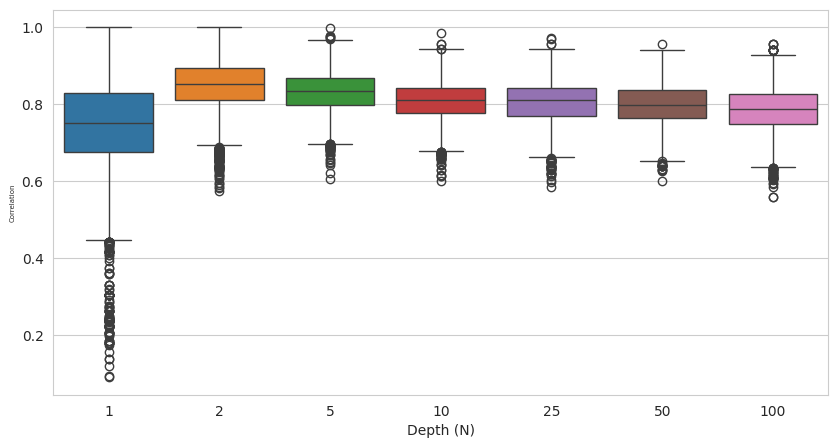

In [26]:
plt.figure(figsize=(10,5));

sns.boxplot(data=cor_df_depth);
plt.xlabel("Depth (N)", size=10);
plt.ylabel("Correlation", size=5);

Опишите ваши наблюдения:

* Где-то после 4 признаков, модели коррелируют одинаково
* Про глубину, на 1 получается очень разнообразные варианты корреляции, может быть модели в целом плохо предсказывают, после глубины 5 тоже наблюдается плато

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [70]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O ../data/heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

/home/folann/miniconda3/envs/ML/lib/python3.12/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [28]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [29]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [30]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

Бустинг был чересчур разговорчивым, поэтому я взяла просто скоры.

1. KNeighborsClassifier 0.649331376
2. SVC 0.697311907
3. DecisionTreeClassifier 0.797997227
4. LGBMClassifier 0.813247863
5. XGBClassifier 0.813452212
6. GaussianNB 0.814067663
7. LGBMClassifier 0.817010632
8. ExtraTreesClassifier 0.828174603
9. RandomForestClassifier 0.832875128
10. CatBoostClassifier 0.834271517
11. SVC 0.840309847
12. VotingClassifier 0.845511038
13. VotingClassifier 0.849444028
14. XGBRFClassifier 0.849947884
15. LogisticRegression 0.850007368


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [31]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

Лучший f1 была у хард варианта. Было сказано, что удалить просто все модели, у которых корреляция больше 0.9 будет недостаточным, но я все равно попробую. Обратимся с корреляционной табличке и удалим все модели из base models, у кого большое значение, и прогоним еще раз.

In [32]:
voting_hard.fit(X_train, y_train)
corrs = base_model_pair_correlation_for_voting_clf(voting_hard, X_train)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [33]:
print(corrs) #это я просто смотрю, что в списке происходит, кортеж модель1, модель2, их корр

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), RandomForestClassifier(n_estimators=50, random_state=111), 0.8682086977280026), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), ExtraTreesClassifier(random_state=111), 0.8021245391305475), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), KNeighborsClassifier(weights='distance'), 0.8021245391305475), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), SVC(kernel='linear', probability=True, random_state=111), 0.8319212449432776), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), SVC(probability=True, random_state=111), 0.5408425748484285), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), <catboost.core.CatBoostClassifier object at 0x7f35ce320050>, 0.8713553220136617), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), LGBMClassifier(random_stat

In [34]:
for comb in corrs:
    if comb[2] > 0.9:
        print(comb[0].__class__.__name__, comb[1].__class__.__name__, comb[2])

DecisionTreeClassifier LGBMClassifier 0.9169113430403553
DecisionTreeClassifier XGBRFClassifier 0.9456478322949043
RandomForestClassifier ExtraTreesClassifier 0.9755705702834908
RandomForestClassifier KNeighborsClassifier 0.9755705702834908
RandomForestClassifier CatBoostClassifier 0.9916646204862014
RandomForestClassifier LGBMClassifier 0.9896757313382182
RandomForestClassifier XGBClassifier 0.984883854522466
RandomForestClassifier XGBRFClassifier 0.9521434872629202
ExtraTreesClassifier KNeighborsClassifier 0.9999999999999999
ExtraTreesClassifier CatBoostClassifier 0.9770581899010486
ExtraTreesClassifier LGBMClassifier 0.9848420743994741
ExtraTreesClassifier XGBClassifier 0.9970199279157617
KNeighborsClassifier CatBoostClassifier 0.9770581899010486
KNeighborsClassifier LGBMClassifier 0.9848420743994741
KNeighborsClassifier XGBClassifier 0.9970199279157617
SVC LogisticRegression 0.964255000257077
CatBoostClassifier LGBMClassifier 0.9951295712418811
CatBoostClassifier XGBClassifier 0.98

Уберу все часто встречающиеся с кем-то коррелирующие модели.

In [35]:
base_models_new = [("DT", dt), ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), ("CAT", cat), ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf), ("NB", nb)]

In [36]:
voting_hard_new = VotingClassifier(estimators=base_models_new, voting='hard')
for model in [dt, cat, svc_lin, svc_rbf, xgb_rf, lgbm_rf, nb, voting_hard_new]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
CatBoostClassifier: 0.8342715174922052
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBRFClassifier: 0.8499478840942256
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151

VotingClassifier: 0.8635542168674698 Попробуем еще потыкаться,.

In [37]:
voting_hard_new.fit(X_train, y_train)
corrs_1 = base_model_pair_correlation_for_voting_clf(voting_hard_new, X_train)
for comb in corrs_1:
    if comb[2] > 0.9:
        print(comb[0].__class__.__name__, comb[1].__class__.__name__, comb[2])

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[

Выкину еще XGBRFClassifier

In [38]:
base_models_new_1 = [("DT", dt), ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), ("CAT", cat), ("LGBM_RF", lgbm_rf), ("NB", nb)]

In [39]:
voting_hard_new_1 = VotingClassifier(estimators=base_models_new_1, voting='hard')
for model in [dt, cat, svc_lin, svc_rbf, lgbm_rf, nb, voting_hard_new_1]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
CatBoostClassifier: 0.8342715174922052
SVC: 0.8403098469098905
SVC: 0.6973119072190279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[Light

Нет, стало хуже VotingClassifier: 0.8427776758970597. Верну на место, уберу CAT, он один раз попадается, но какую-то мощную смуту вносит

In [40]:
base_models_new_2 = [("DT", dt), ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf), ("NB", nb)]

In [41]:
voting_hard_new_2 = VotingClassifier(estimators=base_models_new_2, voting='hard')
for model in [dt, svc_lin, svc_rbf, lgbm_rf, xgb_rf, nb, voting_hard_new_2]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
SVC: 0.8403098469098905
SVC: 0.6973119072190279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pa

VotingClassifier: 0.8689024390243901, так, еще чучуть. 

In [42]:
voting_hard_new_2.fit(X_train, y_train)
corrs_2 = base_model_pair_correlation_for_voting_clf(voting_hard_new_2, X_train)
for comb in corrs_2:
    if comb[2] > 0.9:
        print(comb[0].__class__.__name__, comb[1].__class__.__name__, comb[2])

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[

Тяжелый выбор. Как будто дисжен три мешается, но svc_rbf был сам по себе 0,69. Попробую сначала его выгнать с вечеринки.

In [43]:
base_models_new_3 = [("DT", dt), ("SVC_LIN", svc_lin), ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf), ("NB", nb)]

In [44]:
voting_hard_new_3 = VotingClassifier(estimators=base_models_new_3, voting='hard')
for model in [dt, svc_lin, lgbm_rf, xgb_rf, nb, voting_hard_new_3]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
SVC: 0.8403098469098905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore

VotingClassifier: 0.8615794100823649 упало. Ладно, а если деревья.

In [45]:
base_models_new_4 = [("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf), ("NB", nb)]

In [46]:
voting_hard_new_4 = VotingClassifier(estimators=base_models_new_4, voting='hard')
for model in [svc_lin, svc_rbf, lgbm_rf, xgb_rf, nb, voting_hard_new_4]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

SVC: 0.8403098469098905
SVC: 0.6973119072190279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGB

VotingClassifier: 0.8616656074097867, понятно, не в них дело. А если оба?

In [47]:
base_models_new_5 = [("SVC_LIN", svc_lin), ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf), ("NB", nb)]

In [48]:
voting_hard_new_5 = VotingClassifier(estimators=base_models_new_5, voting='hard')
for model in [svc_lin, lgbm_rf, xgb_rf, nb, voting_hard_new_5]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

SVC: 0.8403098469098905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training

Мда. VotingClassifier: 0.8344322344322345. Ладно, откатимся назад, может в LBGM дело.

In [49]:
base_models_new_6 = [("DT", dt), ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), ("XGB_RF", xgb_rf), ("NB", nb)]

In [50]:
voting_hard_new_6 = VotingClassifier(estimators=base_models_new_6, voting='hard')
for model in [dt, svc_lin, svc_rbf, xgb_rf, nb, voting_hard_new_6]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBRFClassifier: 0.8499478840942256
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8614859608720108


Поменяю в лучшем наборе гаусиану на логистическую регрессиию. Попробую к лучшему набору добавить что-то, что не коррелирует с ним.

In [51]:
base_models_new_7 = [("DT", dt), ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf), ("LR", lr)]

In [52]:
voting_hard_new_7 = VotingClassifier(estimators=base_models_new_7, voting='hard')
for model in [dt, svc_lin, svc_rbf, lgbm_rf, xgb_rf, lr, voting_hard_new_7]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
SVC: 0.8403098469098905
SVC: 0.6973119072190279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pa

VotingClassifier: 0.8644860985646895

In [53]:
voting_hard_new_7.fit(X_train, y_train)
corrs_7 = base_model_pair_correlation_for_voting_clf(voting_hard_new_7, X_train)
for comb in corrs_7:
    if comb[2] > 0.9:
        print(comb[0].__class__.__name__, comb[1].__class__.__name__, comb[2])

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[

In [54]:
base_models_new_9 = [("DT", dt), ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), ("XGB_RF", xgb_rf), ("LR", lr)]

In [55]:
voting_hard_new_9 = VotingClassifier(estimators=base_models_new_9, voting='hard')
for model in [dt, svc_lin, svc_rbf, xgb_rf, lr, voting_hard_new_9]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBRFClassifier: 0.8499478840942256
LogisticRegression: 0.8500073681108163
VotingClassifier: 0.8625767437566357


Хорошо, поменяем типы того, что было в лучшем наборе.

In [56]:
base_models_new_10 =[("DT", dt), ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), ("LGBM", lgbm), ("XGB_RF", xgb_rf), ("NB", nb)]

In [57]:
voting_hard_new_10 = VotingClassifier(estimators=base_models_new_10, voting='hard')
for model in [dt, svc_lin, svc_rbf, lgbm, xgb_rf, nb, voting_hard_new_10]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
SVC: 0.8403098469098905
SVC: 0.6973119072190279
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [58]:
voting_hard_new_10.fit(X_train, y_train)
corrs_10 = base_model_pair_correlation_for_voting_clf(voting_hard_new_10, X_train)
for comb in corrs_10:
    if comb[2] > 0.9:
        print(comb[0].__class__.__name__, comb[1].__class__.__name__, comb[2])

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [59]:
base_models_new_11 = [("DT", dt), ("SVC_RBF", svc_rbf), ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf), ("NB", nb)]

In [60]:
voting_hard_new_11 = VotingClassifier(estimators=base_models_new_11, voting='hard')
for model in [dt, svc_rbf, lgbm_rf, xgb_rf, nb, voting_hard_new_11]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
SVC: 0.6973119072190279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore

### VotingClassifier: 0.8747183857380744 ПОЧЕМУ Я СРАЗУ НЕ УБРАЛА SVC_LIN.....
#### base_models_new_11 = [("DT", dt), ("SVC_RBF", svc_rbf), ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf), ("NB", nb)]

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [63]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [64]:
data.isna().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [65]:
data['Churn?'].value_counts()

Churn?
False.    2850
True.      483
Name: count, dtype: int64

In [66]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [67]:
def detect_variable_types(df):
  variable_types = {'categorical': [], 'numerical': []}
  for column in df.columns:
    if df[column].dtype == 'object':
      variable_types['categorical'].append(column)
    elif df[column].dtype in [np.int64, np.float64]:
      variable_types['numerical'].append(column)
  return variable_types
variables = detect_variable_types(data)
variables

{'categorical': ['State', 'Phone', "Int'l Plan", 'VMail Plan', 'Churn?'],
 'numerical': ['Account Length',
  'Area Code',
  'VMail Message',
  'Day Mins',
  'Day Calls',
  'Day Charge',
  'Eve Mins',
  'Eve Calls',
  'Eve Charge',
  'Night Mins',
  'Night Calls',
  'Night Charge',
  'Intl Mins',
  'Intl Calls',
  'Intl Charge',
  'CustServ Calls']}

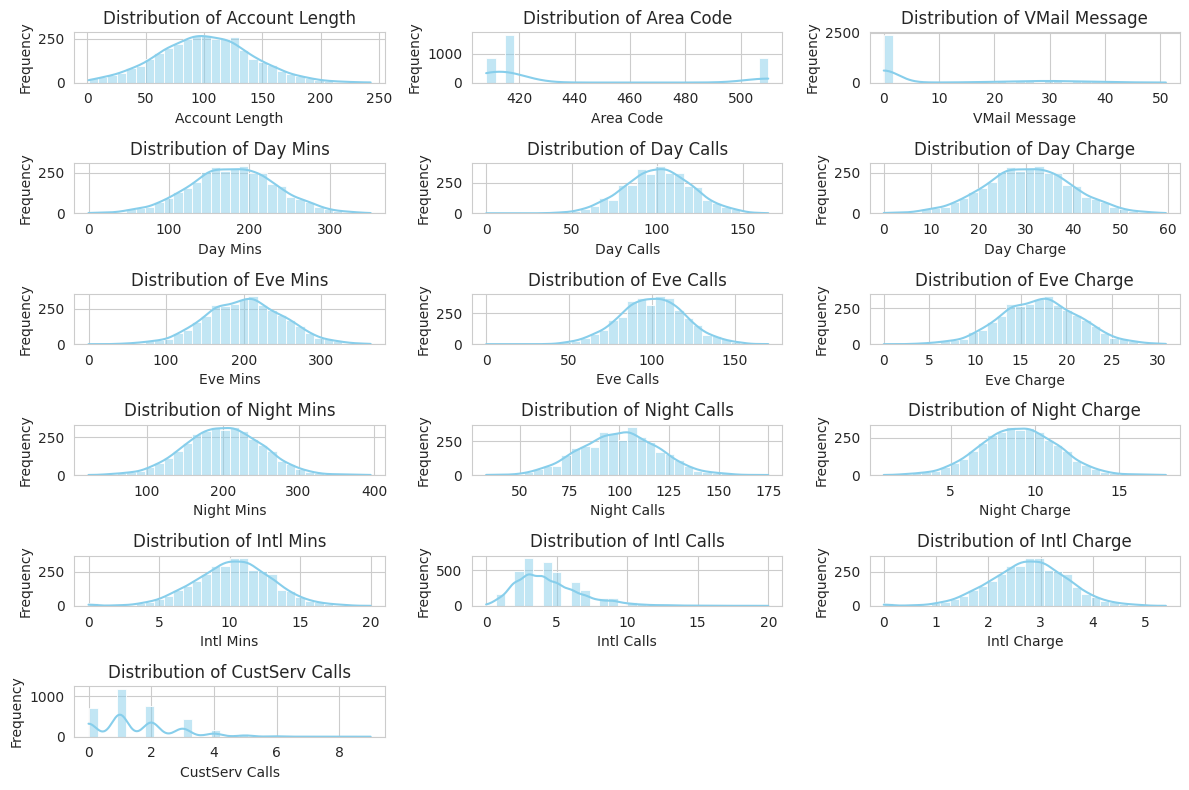

In [68]:
numerical_columns = variables['numerical']
plt.figure(figsize=(12, 8))
num_cols = 3
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols
for i, column in enumerate(numerical_columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(data[column], bins=30, color='skyblue', kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Пропущенных нет, надеюсь, перекос в большое количество не ушедших не помешает, надо будет закодировать все категориальные переменные plan, churn, и удалить штат, Account Length, Area Code, Phone.

Ладно, я сдалась на этом этапе, извините :(

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

Рисовали в художке. Лучшей передачи не будет. 

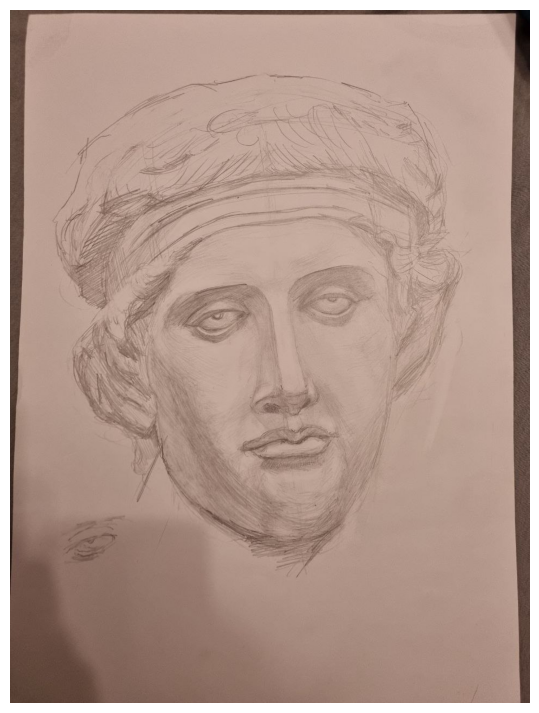

In [69]:
import matplotlib.image as mpimg
image = mpimg.imread("../data/face.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**